# Previsão de Preços de Seguro de Saúde

https://www.kaggle.com/datasets/mirichoi0218/insurance

Os dados seguem a seguinte estrutura:

* age:	Idade do beneficiário
* sex:	Genêro
* bmi:	O IMC (Índice de Massa Corporal) do beneficiário
* children:	Número de dependentes cobertos pelo seguro
* smoker:	Fumante (sim ou não)
* region:	a área residencial do beneficiário nos EUA (nordeste, sudeste, sudoeste, noroeste)
* charges:	Os custos individuais do seguro



In [ ]:
#importando as bibliotecas
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn import tree

# 1. Entendendo os dados

In [ ]:
#leitura dos dados
df = pd.read_csv('./insurance_AP2.csv', sep=',', encoding='utf-8')

In [ ]:
#vizualizar os dados
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
#verificando o tamanho do dataset
df.shape

(1338, 7)

In [ ]:
#imprimindo um resumo, incluindo o tipo de índice e colunas, valores não nulos e uso de memória.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Podemos observar que não há dados nulos na base, portanto não vamos precisar fazer esse tipo de tratamento.

In [ ]:
#apagando as linhas duplicadas e verificando o tamanho do dataset novamente
df = df.reset_index(drop=True).drop_duplicates()
df.shape

(1337, 7)

Havia apenas uma linha duplicada no dataset, foi apagada para evitar  viéses nas análises e na modelagem.

# 2. Análise exploratória

In [ ]:
#estatísiticas descritivas
df.describe().round(4)

,age,bmi,children,charges
count,1337.0000,1337.0000,1337.0000,1337.0000
mean,39.2221,30.6635,1.0957,13279.1215
std,14.0443,6.1005,1.2056,12110.3597
min,18.0000,15.9600,0.0000,1121.8739
25%,27.0000,26.2900,0.0000,4746.3440
50%,39.0000,30.4000,1.0000,9386.1613
75%,51.0000,34.7000,2.0000,16657.7174
max,64.0000,53.1300,5.0000,63770.4280


* **Média:**
A média de idade é de aproximadamente 39 anos, indicando que a população é composta majoritariamente por adultos de meia-idade. O índice de massa corporal (BMI) médio é de cerca de 30.66, o que sugere que a média está na faixa de obesidade (índice acima de 25 indica sobrepeso e acima de 30 já está em obesidade.). Em média, as pessoas têm aproximadamente 1 filho. A média dos custos médicos (charges) é de 13279.12, o que sugere que os custos podem variar significativamente, dado o desvio padrão alto.

* **Desvio Padrão:**
O desvio padrão para a idade é de 14.04 anos, indicando uma variabilidade razoável nas idades dos indivíduos. O desvio padrão do BMI é 6.10, mostrando uma variação considerável no índice de massa corporal. O número de filhos também tem um desvio padrão de 1.21, sugerindo que a maioria das pessoas tem de 0 a 2 filhos. O desvio padrão dos custos médicos é alto (12110.36), indicando que os custos variam amplamente entre os indivíduos.

* **Valores Mínimos:**
A idade mínima é 18, indicando que o conjunto de dados não inclui menores de idade. O BMI mínimo é 15.96, que está na faixa de baixo peso. Algumas pessoas não têm filhos (children = 0). O menor custo médico registrado é 1121.87.

* **Quartis:**
Para a idade, 25% das pessoas têm 27 anos ou menos, a mediana é 39 anos, e 75% têm 51 anos ou menos. Isso mostra uma distribuição relativamente equilibrada de idades, com uma leve concentração em idades mais jovens. O BMI segue um padrão semelhante, com 25% das pessoas abaixo de 26.29, a mediana sendo 30.4, e 75% abaixo de 34.7. Em relação ao número de filhos, metade das pessoas têm até 1 filho, e 75% têm até 2 filhos. Para os custos médicos, 25% das pessoas têm custos abaixo de 4746.34, a mediana é 9386.16, e 75% têm custos abaixo de 16657.72. Isso indica que a distribuição de custos médicos é assimétrica, com alguns valores muito altos. (Vamos analisar graficamente através do box-plot mais adiante).

* **Valores Máximos:**
A idade máxima é 64 anos. O BMI máximo é 53.13, que está na faixa de obesidade. O número máximo de filhos é 5. O maior custo médico registrado é 63770.43, sugerindo que há alguns indivíduos com custos médicos muito altos.

* As variáveis qualitativas sex, smoker, region serão avaliadas mais adiante.

# 3.1. O comportamento das variáveis de entrada (X)


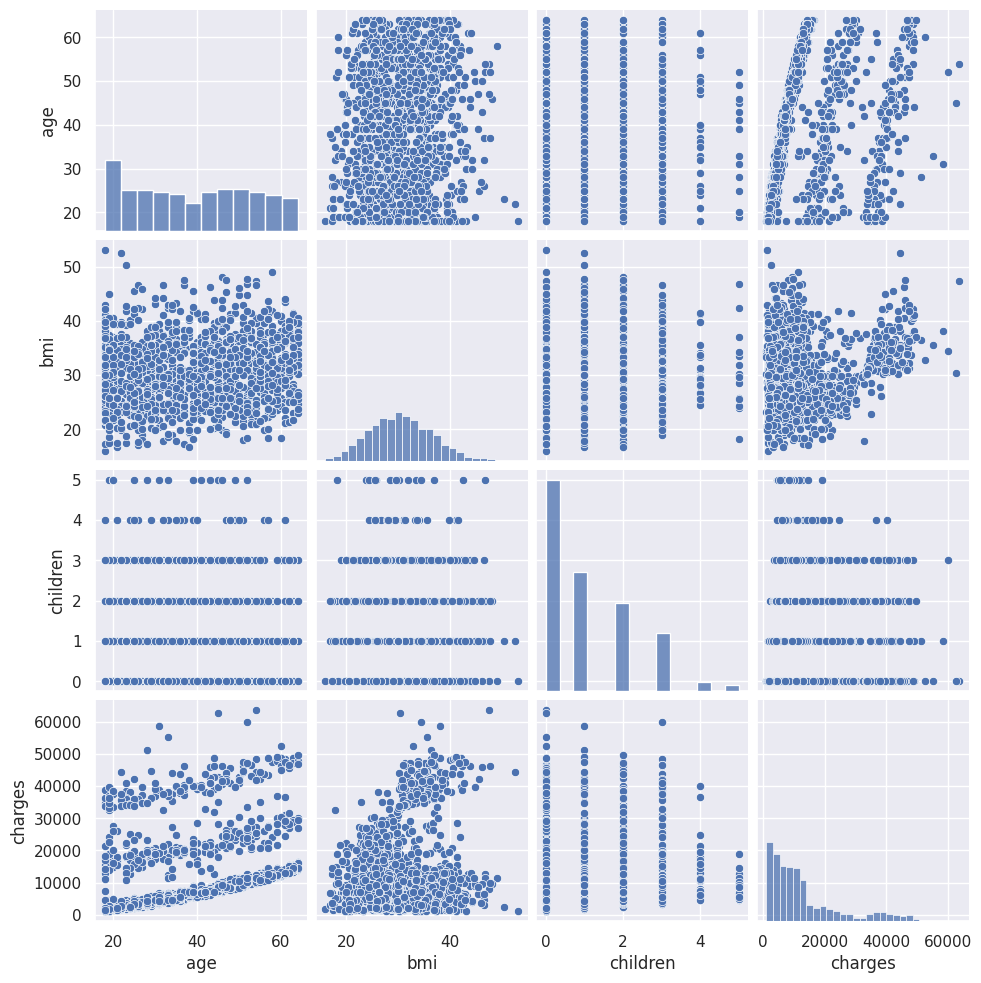

In [ ]:
#plotando o relacionamento de pares de variáveis da base
ax = sns.pairplot(df)

Avaliando as variáveis no gráfico acima, em geral é uma base sem linearidade a não ser entre as variáveis idade x custos e bmi x custos. a variável children é discreta, por ter características mensuráveis, o gráfico demonstra esse comportamento (demonstrando a "contagem").  As variáveis categóricas (fumante e sexo) serão avaliadas separadamente mais adiante. É possivel identificar também que a variável bmi assume uma distribuição normal, ja as variáveis age, children e charges a maior parte dos dados estão concentrados na faixa inicial do gráfico.

In [ ]:
#verificando a frequência relativa das variáveis categóricas (sex)
sex_freq = df['sex'].value_counts().reset_index()
sex_freq['proportion'] = ((df['sex'].value_counts(normalize = True).values) * 100).round(2)
sex_freq

,sex,count,proportion
0,male,675,50.49
1,female,662,49.51


In [ ]:
fig = px.bar(sex_freq, x='sex', y='count', title='Distribuição do Gênero', labels={'sex':'Gênero', 'count':'Contagem'},
             color='sex')
fig.update_layout(showlegend=False)
fig.show()

A base contém uma diferença muito pequena na proporção entre homens e mulheres, a base está bem dividida entre sexo.

In [ ]:
#verificando a frequência relativa das variáveis categóricas (smoker)
smoker_freq = df['smoker'].value_counts().reset_index()
smoker_freq['proportion'] = ((df['smoker'].value_counts(normalize = True).values) * 100).round(2)
smoker_freq

,smoker,count,proportion
0,no,1063,79.51
1,yes,274,20.49


A proporção de pessoas não fumantes (79,51%) é relativamente maior que as pessoas fumantes (20,49%) na nossa base de dados.

In [ ]:
#plotando o gráfico da distribuição de fumantes
fig = px.bar(smoker_freq, x='smoker', y='count', title='Distribuição por Fumantes', labels={'smoker':'Fumante', 'count':'Contagem'}, color='smoker')
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
#contagem de fumantes por gênero
sex_freq2 = df.groupby(['sex', 'smoker'])[['smoker']].count()
sex_freq2

smoker
sex    smoker        
female no         547
       yes        115
male   no         516
       yes        159

A maioria da base entre homens e mulheres é não fumante.

In [ ]:
#verificando a frequência relativa (region)
region_freq = df['region'].value_counts().reset_index()
region_freq['proportion'] = ((df['region'].value_counts(normalize = True).values) * 100).round(2)
region_freq

,region,count,proportion
0,southeast,364,27.23
1,southwest,325,24.31
2,northwest,324,24.23
3,northeast,324,24.23


In [ ]:
#plotando o gráfico da distribuição de regiões
fig = px.bar(region_freq, x='region', y='count', title='Distribuição por Região', labels={'region':'Região', 'count':'Contagem'}, color='region')
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
#contagem de fumantes por região
smoker_region_proportion = df[(df['smoker'] == 'yes')].groupby(['region'])['smoker'].value_counts().reset_index()
smoker_region_proportion

,region,smoker,count
0,northeast,yes,67
1,northwest,yes,58
2,southeast,yes,91
3,southwest,yes,58


# 3.2. O comportamento da variável dependente (Y)

In [ ]:
fig = px.histogram(df, x='charges', nbins=30, title='Distribuição dos Custos')
fig.show()

Nossa variável independente mostra um comportamento diferente da normal em sua distribuição. Vamos visualizar um boxplot para ter outra perspectiva da distribuição.

In [ ]:
#investigando a variável resposta através do gráfico BoxPlot
fig = px.box(df, y='charges')
fig.update_layout(title='Boxplot Custos')
fig.show()

Apesar da existência de outliers, pela quantidade limitada de dados vou optar por não remover estes registros. Depois de avaliar todas as variáveis com nossa variável resposta, vamos investigar melhor se faz sentido mante-los na base de dados.

In [ ]:
#gráfico de dispersão entre as variáveis idade e custo, separado por sexo
fig = px.scatter(df, x='age', y='charges', color='sex',
                 trendline='ols', title= 'Gráfico de Dispersão - Idade x Custos')
fig.show()

Através do gráfico acima podemos identificar que existe certa correlação entre o custo e a idade, o que faz sentido ja que quanto maior a idade do beneficiário maior os gastos com saúde consequentemente maior o custo.

In [ ]:
#investigando a variável resposta através do gráfico BoxPlot, comparando com o sexo.
fig = px.box(df, x='sex', y='charges', color='sex')
fig.update_layout(title='Boxplot Gênero x Custos', showlegend=False)
fig.show()

Apesar do equilibrio na distribuição entre homens e mulheres, através do gráfico podemos ver que os homens tem custos mais altos com seguro saúde.

In [ ]:
#plotando um gráfico de dispersão entre IMC x Custos
fig = px.scatter(df, x='bmi', y='charges', color='smoker',
                 trendline='ols', title='Gráfico de Dispersão - IMC x Custos')
fig.show()

Através do grafico podemos identificar que existe relação entre IMC e o Custos, quanto maior o IMC maiores os custos com saúde também. Podemos verificar que as pessoas fumantes possuem gastos maiores com saúde também e existe linearidade entra as variáveis fumantes e custos.

In [ ]:
#investigando a variável resposta através do gráfico BoxPlot, comparando com região.
fig = px.box(df, x='region', y='charges',color='region')
fig.update_layout(title='Boxplot Região x Custos', showlegend=False)
fig.show()

In [ ]:
#investigando a variável resposta através do gráfico BoxPlot, comparando com smoker.
fig = px.box(df, x='smoker', y='charges', color='smoker')
fig.update_layout(title='Boxplot Fumante x Custos', showlegend=False)
fig.show()

Avaliando o boxplot acima, confirmamos que ser fumante é um fator muito preponderante nos custos, elevando os gastos com saude. Podemos ver que o valor máximo de 63k não é considerado um outilier entre as pessoas fumantes.

In [ ]:
#investigando os outliers de custos no primeiro gráfico boxplot.
df_charges = df[df["charges"] > 34472]
df_charges

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


In [ ]:
#agrupando e contando a quantidade de fumantes no df_charges
df_charges.groupby(['smoker'])[['smoker']].count()

,smoker
smoker,
no,3
yes,137


Podemos verificar que dos 140 valores outliers 137 são pessoas fumantes e como vimos anteriormente, as duas variáveis possuem linearidade e por este motivo vamos manter os valores como outliers.

# 4. Feature engineering

In [ ]:
#fazendo uma cópia do dataframe original para não perder os dados
df_tratamento = df.copy()
df_tratamento.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
#aplicando transformação logaritmica na variável dependente
df_tratamento['charges'] = np.log(df['charges'])
df_tratamento

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,9.734176
1,18,male,33.770,1,no,southeast,7.453302
2,28,male,33.000,3,no,southeast,8.400538
3,33,male,22.705,0,no,northwest,9.998092
4,32,male,28.880,0,no,northwest,8.260197
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,9.268661
1334,18,female,31.920,0,no,northeast,7.698927
1335,18,female,36.850,0,no,southeast,7.396233
1336,21,female,25.800,0,no,southwest,7.604867


In [ ]:
#plotando o gráfico para verificar a distribuição após transformação
fig = px.histogram(df_tratamento, x='charges', nbins=30, title='Distribuição dos Custos')
fig.show()

Vemos como após a transformação, apesar da variável não estar assumindo uma distribuição normal perfeita, está muito melhor distribuída do que antes.

In [ ]:
#transformando a variável sex em dummie (male = 1)
df_tratamento['sex'] = np.where(df_tratamento['sex'] == 'female', 0, 1)
df_tratamento

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,9.734176
1,18,1,33.770,1,no,southeast,7.453302
2,28,1,33.000,3,no,southeast,8.400538
3,33,1,22.705,0,no,northwest,9.998092
4,32,1,28.880,0,no,northwest,8.260197
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,no,northwest,9.268661
1334,18,0,31.920,0,no,northeast,7.698927
1335,18,0,36.850,0,no,southeast,7.396233
1336,21,0,25.800,0,no,southwest,7.604867


In [ ]:
#transformando a variável smoker em dummie (smoker = 1)
df_tratamento['smoker'] = np.where(df_tratamento['smoker'] == 'yes', 1, 0)
df_tratamento

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,9.734176
1,18,1,33.770,1,0,southeast,7.453302
2,28,1,33.000,3,0,southeast,8.400538
3,33,1,22.705,0,0,northwest,9.998092
4,32,1,28.880,0,0,northwest,8.260197
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,northwest,9.268661
1334,18,0,31.920,0,0,northeast,7.698927
1335,18,0,36.850,0,0,southeast,7.396233
1336,21,0,25.800,0,0,southwest,7.604867


In [ ]:
#criando uma variável indicando se a pessoa tem filho ou não
df_tratamento['has_children'] = (df_tratamento['children'] > 0).astype(int)

In [ ]:
#criando uma variável para interação entre Idade e BMI
df_tratamento['age_bmi'] = df_tratamento['age'] * df_tratamento['bmi']

In [ ]:
#criando uma variável para interação entre Idade e Filhos
df_tratamento['age_children'] = df_tratamento['age'] * df_tratamento['children']

In [ ]:
#criando uma variável de preço por criança
df_tratamento['charge_child'] = df_tratamento['charges'] / df_tratamento['children']

In [ ]:
#corrigindo os valores das divisões por 0 filhos
df_tratamento['charge_child'] = df_tratamento['charge_child'].replace(np.inf, 0)

In [ ]:
#classificação de BMI
from sklearn.preprocessing import LabelEncoder
df_tratamento['bmi_category'] = pd.cut(df_tratamento['bmi'], bins=[0, 18.5, 24.9, 29.9, np.inf], labels=['abaixo do peso', 'normal', 'sobrepeso', 'obeso'])

In [ ]:
#transformando variaveis categoricas (bmi_category) para numerico
le = LabelEncoder()
le.fit(df_tratamento['bmi_category'])
df_tratamento['bmi_category_dummie'] = le.transform(df_tratamento['bmi_category'])

In [ ]:
#classificação de idade em grupos
df_tratamento['age_group'] = pd.cut(df['age'], bins=[0, 18, 60, np.inf], labels=['criança', 'adulto', 'idoso'])

In [ ]:
#transformando variaveis categoricas (age_group) para numerico
le = LabelEncoder()
le.fit(df_tratamento['age_group'])
df_tratamento['age_group_dummie'] = le.transform(df_tratamento['age_group'])

In [ ]:
#transformando variaveis categoricas para numerico
le = LabelEncoder()
le.fit(df_tratamento['region'])
df_tratamento['region_dummie'] = le.transform(df_tratamento['region'])

In [ ]:
#média de fumantes por região
smoker_region_proportion = df_tratamento.groupby('region')['smoker'].mean().reset_index().rename(columns={'smoker': 'smoker_per_region'})
df_tratamento = df_tratamento.merge(smoker_region_proportion, on='region', how='left')

In [ ]:
df_tratamento.head()

,age,sex,bmi,children,smoker,region,charges,has_children,age_bmi,age_children,charge_child,bmi_category,bmi_category_dummie,age_group,age_group_dummie,region_dummie,smoker_per_region
0,19,0,27.900,0,1,southwest,9.734176,0,530.100,0,0.000000,sobrepeso,3,adulto,0,3,0.178462
1,18,1,33.770,1,0,southeast,7.453302,1,607.860,18,7.453302,obeso,2,criança,1,2,0.250000
2,28,1,33.000,3,0,southeast,8.400538,1,924.000,84,2.800179,obeso,2,adulto,0,2,0.250000
3,33,1,22.705,0,0,northwest,9.998092,0,749.265,0,0.000000,normal,1,adulto,0,1,0.179012
4,32,1,28.880,0,0,northwest,8.260197,0,924.160,0,0.000000,sobrepeso,3,adulto,0,1,0.179012


In [ ]:
#matriz de correlação
df_tratamento.corr(numeric_only=True)

,age,sex,bmi,children,smoker,charges,has_children,age_bmi,age_children,charge_child,bmi_category_dummie,age_group_dummie,region_dummie,smoker_per_region
age,1.000000,-0.019814,0.109344,0.041536,-0.025587,0.526927,0.045892,0.879702,0.252680,0.062613,0.052346,0.274619,0.001626,-0.012390
sex,-0.019814,1.000000,0.046397,0.017848,0.076596,0.007009,0.015978,0.007179,-0.001159,0.012805,0.014595,-0.007575,0.004936,0.017878
bmi,0.109344,0.046397,1.000000,0.012755,0.003746,0.132822,0.016079,0.539920,0.048980,0.020993,0.196434,0.084332,0.157574,0.231352
children,0.041536,0.017848,0.012755,1.000000,0.007331,0.160336,0.787420,0.042397,0.927348,0.332329,-0.011533,-0.143286,0.016258,-0.034368
smoker,-0.025587,0.076596,0.003746,0.007331,1.000000,0.665718,0.009093,-0.023419,0.004878,0.053364,-0.031240,0.015731,-0.002358,0.073780
charges,0.526927,0.007009,0.132822,0.160336,0.665718,1.000000,0.152843,0.492054,0.242089,0.151523,0.025099,0.100498,-0.043393,0.033161
has_children,0.045892,0.015978,0.016079,0.787420,0.009093,0.152843,1.000000,0.045797,0.733870,0.823040,0.004559,-0.184070,0.013289,-0.015117
age_bmi,0.879702,0.007179,0.539920,0.042397,-0.023419,0.492054,0.045797,1.000000,0.235005,0.059221,0.112731,0.276219,0.074256,0.086971
age_children,0.252680,-0.001159,0.048980,0.927348,0.004878,0.242089,0.733870,0.235005,1.000000,0.320516,0.007730,-0.078480,0.017677,-0.023082
charge_child,0.062613,0.012805,0.020993,0.332329,0.053364,0.151523,0.823040,0.059221,0.320516,1.000000,0.031165,-0.147469,0.003065,0.016849


Vamos avaliar a correlação de pearson de cada variável com nossa variável resposta charges:

- age: a cada aumento na idade do beneficiário, existe um aumento de 52% no aumento do custo.
- bmi: a cada aumento de bmi, os custos com saúde aumentam 13% para os beneficiários.
- children: o custo com saúde aumenta 16% a cada aumento de dependentes.
- sex: não existe grande diferença no seguro independente do sexo do beneficiário (0.70%).
- smoker: é a variável com maior correlação, se a pessoa for fumante, os custos com a saúde aumentam 66%. Provavelmente, essa será a variável mais importante para predição dos custos.
- has_children: se a pessoa possui filho, independente da quantidade de dependentes, o custo com saude aumenta 15%.
- e assim sucessivamente para todas as variáveis.

<Axes: >

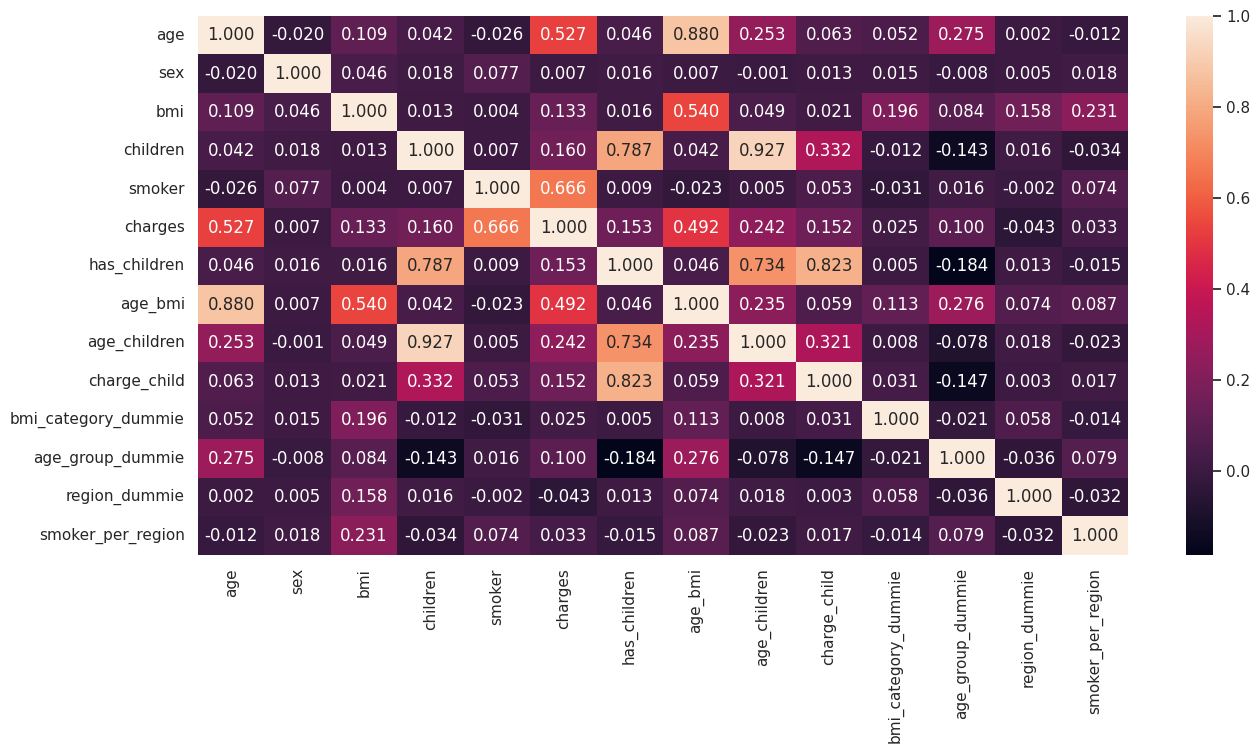

In [ ]:
#mapa de calor
sns.set(rc={"figure.figsize": (15, 7)})
sns.heatmap(df_tratamento.corr(numeric_only=True), annot=True, fmt=".3f")

Podemos confirmar que a correlação entre as variáveis da nossa base em sua maioria são neutras, com exceção das variáveis idade, bmi e fumante que vimos linearidade com a variavel custos nos gráficos apresentados acima.

É possível notar também que as variáveis criadas, são alto explicativas pois possuem alta correlação entre elas. Portanto as variáveis has_children, age_bmi, age_children não serão selecionadas para o treinamento do nosso modelo.

In [ ]:
df_tratamento.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'has_children', 'age_bmi', 'age_children', 'charge_child',
       'bmi_category', 'bmi_category_dummie', 'age_group', 'age_group_dummie',
       'region_dummie', 'smoker_per_region'],
      dtype='object')

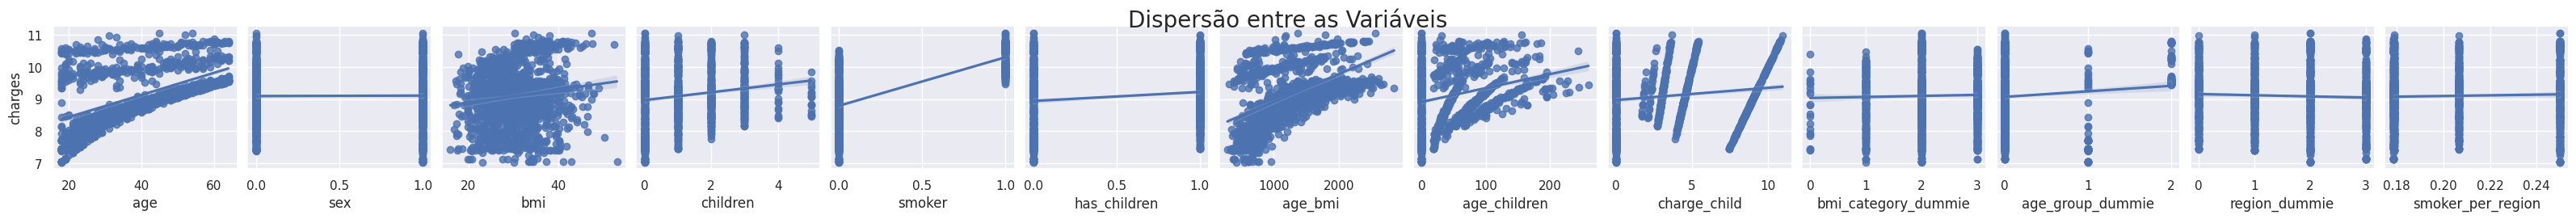

In [ ]:
#plotando relacionamento entre pares entre nossas variáveis de entrada e resposta.
ax = sns.pairplot(df_tratamento, y_vars='charges', x_vars=[
       'age', 'sex', 'bmi', 'children', 'smoker'
        ,'has_children', 'age_bmi', 'age_children', 'charge_child',
       'bmi_category_dummie', 'age_group_dummie',
       'region_dummie', 'smoker_per_region'],
        kind='reg')
ax.fig.suptitle('Dispersão entre as Variáveis', fontsize=20, y=1.05)
ax

Após a criação das variáveis, podemos confirmar que existe linearidade entre as variáveis de entrada (age, bmi, children, smoker, has_children, age_bmi, age_children, charge_child, bmi_category_dummie, age_group_dummie, region_dummie sendo descendente e smoker_per_region poquíssima) e nossa variável resposta (charge). Podemos dizer também que existem faixas de preços dependendo da idade. E quanto as variáveis smoker e has_children os dados tem patamares diferentes a depender da entrada, o custo de fato aumenta.

# 5. Regressão Linear

In [ ]:
#armazenando os custos (y)
y = df_tratamento['charges']

#y = df['charges']

In [ ]:
df_tratamento.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'has_children', 'age_bmi', 'age_children', 'charge_child',
       'bmi_category', 'bmi_category_dummie', 'age_group', 'age_group_dummie',
       'region_dummie', 'smoker_per_region'],
      dtype='object')

In [ ]:
#armazenando as variáveis dependentes (x)

#X = df_tratamento[['age', 'bmi', 'children',
#       'sex', 'smoker', 'charge_child']]

X = df_tratamento[['age', 'sex', 'bmi', 'children', 'smoker',
       'charge_child', 'bmi_category_dummie', 'age_group_dummie',
       'region_dummie', 'smoker_per_region']]

In [ ]:
#criando os datasets de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Fazendo a amostragem para o modelo, 70% dos dados foram separados para treino e 30% para teste.

In [ ]:
X_train.shape

(935, 10)

In [ ]:
X_test.shape

(402, 10)

In [ ]:
#instanciando a classe LinearRegression
linreg = LinearRegression()

In [ ]:
#treinando o modelo com o conjunto de dados de treinamento
reg = linreg.fit(X_train, y_train)

In [ ]:
#obtendo o coeficiente de determinação (R²) da base de treino
reg.score(X_train, y_train)

0.7588135182694051

- Coeficiente de determinação: ele nos diz que o modelo está 75% ajustado com base nos dados reais, o modelo explica 75% da variação da resposta e pode ser considerado um bom modelo.

Testamos o modelo com apenas algumas das variáveis e o resultado de R² foi praticamente o mesmo para as que decidimos usar.

In [ ]:
#gerando previsões para os dados X_test
y_pred = reg.predict(X_test)
df_predito = pd.DataFrame(y_pred, columns=['predito'])

#revertendo a transformação logaritmica para verificarmos os valores reais do predito
df_predito['predito'] = np.exp(df_predito['predito'])
df_predito

,predito
0,7549.331846
1,5363.287020
2,13460.210371
3,28427.240031
4,5472.064510
...,...
397,5934.656574
398,11109.962921
399,11192.607363
400,11844.679196


In [ ]:
#obtendo o coeficiente de determinação (R²) para as previsões do nosso modelo
metrics.r2_score(y_test, y_pred)

0.7953704790816112

Inicialmente usamos apenas as variáveis age, bmi, children, sex, smoker, charge_child e apresentou um coeficiente de 78%. Neste modelo que rodamos com mais variáveis houve uma melhora para 79.5%. Como na base de teste apresentou um coeficiente de determinação superior ao da base de treino, ou seja, está capturando uma quantidade significativa da variabilidade nos dados de treino podemos concluir que é um bom modelo.

In [ ]:
#obtendo o intercepto do modelo
np.exp(reg.intercept_)

1234.9113065241518

Quando todas as variáveis de entrada forem iguais a zero, nosso efeito médio será de 1234.91 dólares na variável reposta custo.

In [ ]:
#obtendo os coficientes de regressão
np.exp(reg.coef_)

array([1.0353522 , 0.92645961, 1.0136004 , 1.08549841, 4.6759523 ,
       1.00825767, 0.99933386, 0.93568212, 0.95886495, 0.56250089])

In [ ]:
#transformando os parametros em dataframe
df_coef = pd.DataFrame([X.columns.tolist(), np.exp(reg.coef_)]).T.rename(columns={0:'variavel',1:'parametro'})
df_coef

,variavel,parametro
0,age,1.035352
1,sex,0.92646
2,bmi,1.0136
3,children,1.085498
4,smoker,4.675952
5,charge_child,1.008258
6,bmi_category_dummie,0.999334
7,age_group_dummie,0.935682
8,region_dummie,0.958865
9,smoker_per_region,0.562501


- age: Mantendo-se os valores das demais variáveis x constantes, o acréscimo de 1 ano gera uma variação média no custo de 1.034 dólares.

- bmi: Mantendo-se os valores das demais variáveis x constantes, o acréscimo de 1% de bmi gera uma variação média no custo de 1.011 dólares.

- children: Mantendo-se os valores das demais variáveis x constantes, o acréscimo de 1 filho gera uma variação média no custo de 1.089 dólares.

- sex: Mantendo-se os valores das demais variáveis x constantes, se a pessoa for homem gera uma variação média no custo de 0.93 dólares.

- smoker: Mantendo-se os valores das demais variáveis x constantes, se a pessoa for fumante gera uma variação média no custo de 4.648 dólares. (a mais relevante) Vimos no gráfico que é uma das retas com mais inclinação.

- charge_child: Mantendo-se os valores das demais variáveis x constantes, o acréscimo do custo por criança gera uma variação média no custo de 1.00 dólares.

- region_dummie: Mantendo-se os valores das demais variáveis x constantes, o acréscimo do custo conforme a dummie região "aumenta" gera uma variação média no custo de 0.95 dólares.

In [ ]:
y_pred_train = reg.predict(X_train.reset_index(drop=True))
y_pred_train = pd.DataFrame(y_pred_train, columns=['predito'])

In [ ]:
#plotando gráfico de dispesão dos dados observados e os dados preditos
px.scatter(x=y_train, y=y_pred_train.predito,trendline="ols")

No eixo x (dados observados, ou seja, o custo real) e no y (a previsão do modelo). Vemos que no geral é um ótimo modelo, pois os dados seguem uma linearidade, em sua maioria, a não ser a partir do custo real acima de 9.5.

In [ ]:
#obtendo os resíduos
junto = pd.concat([y_pred_train, y_train.reset_index(drop=True)], axis=1)
junto = np.exp(junto)
junto

,predito,charges
0,12973.578351,27322.73386
1,48523.193135,42303.69215
2,23091.287764,42112.23560
3,35502.491422,41676.08110
4,45368.284681,44202.65360
...,...,...
930,59460.482772,44641.19740
931,5262.031149,3693.42800
932,2833.972150,1964.78000
933,7022.918846,7151.09200


In [ ]:
#calculando o erro absoluto
junto['erros'] = junto.predito - junto.charges
junto

,predito,charges,erros
0,12973.578351,27322.73386,-14349.155509
1,48523.193135,42303.69215,6219.500985
2,23091.287764,42112.23560,-19020.947836
3,35502.491422,41676.08110,-6173.589678
4,45368.284681,44202.65360,1165.631081
...,...,...,...
930,59460.482772,44641.19740,14819.285372
931,5262.031149,3693.42800,1568.603149
932,2833.972150,1964.78000,869.192150
933,7022.918846,7151.09200,-128.173154


In [ ]:
#plotando gráfico de dispersão entre os resíduos e o erro
px.scatter(x=junto.predito, y=junto.erros)

Como o gráfico em boa parte dele, demonstra linearidade entre os resíduos vs. os valores preditos indica algum problema com o modelo como Multicolinearidade (Pode haver um alto grau de correlação entre as variáveis independentes, o que pode levar a um ajuste inadequado do modelo e a padrões nos resíduos.) o que acredito que não seja, ou Heterocedasticidade (A variância dos resíduos pode não ser constante ao longo dos valores preditos) entre alguns outros que pesquisamos.

Para corrigir o problema seria necessário investigar e aprofundar em outras técnicas.

# 6. Árvore Regressora

In [ ]:
df_tratamento.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'has_children', 'age_bmi', 'age_children', 'charge_child',
       'bmi_category', 'bmi_category_dummie', 'age_group', 'age_group_dummie',
       'region_dummie', 'smoker_per_region'],
      dtype='object')

In [ ]:
X = df_tratamento[[
      'age', 'sex', 'bmi', 'children', 'smoker',
       'has_children', 'age_bmi', 'age_children', 'charge_child',
       'bmi_category_dummie', 'age_group_dummie',
       'region_dummie', 'smoker_per_region']]

#usando a variável resposta do df original (sem a transformação logaritmica)
y = df['charges']

#y = df_tratamento['charges']

In [ ]:
#criando os datasets de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#instanciando a classe DecisionTreeRegressor
modelo = DecisionTreeRegressor(random_state=0, max_depth=3, criterion='absolute_error')

Vamos usar um modelo com profundidade 3 para não causar overfiting e o erro absoluto (é a diferença entre o valor medido e o valor real) como critério, o random state será usado para manter o mesmo conjunto em todo treinamento.

In [ ]:
#treinando o modelo
modelo.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=3, random_state=0)

In [ ]:
#gerando previsões para a base X_test
previsao = modelo.predict(X_test)

In [ ]:
#Obtendo o coeficiente de determinação (R²) e o erro absoluto
from sklearn.metrics import mean_absolute_error
from  sklearn import metrics
print(metrics.r2_score(y_test, previsao))
print(mean_absolute_error(y_test, previsao))

0.8472028102665383
2603.2332092761194


- Coeficiente de determinação: ele nos diz que o modelo está 84,72% ajustado com base nos dados reais, o modelo explica 84,72% da variação.

- Erro médio: Quando o modelo erra na previsão, ele erra 2603.23 dólares para mais ou para menos. Considerando o range da nossa variável resposta custo, o erro absoluto está relativamente baixo.

Rodamos o modelo com a variável resposta transformada logaritmica e apresentou um coeficiente de 79%, ou seja, com a variável transformada o modelo não conseguiu capturar corretamente os valores reais pelo fato da base não ter sofrido a mesma transformação. Talvez se aplicassemos a transformação logaritmica na base toda, o resultado seria mais positivo.

In [ ]:
from sklearn import tree

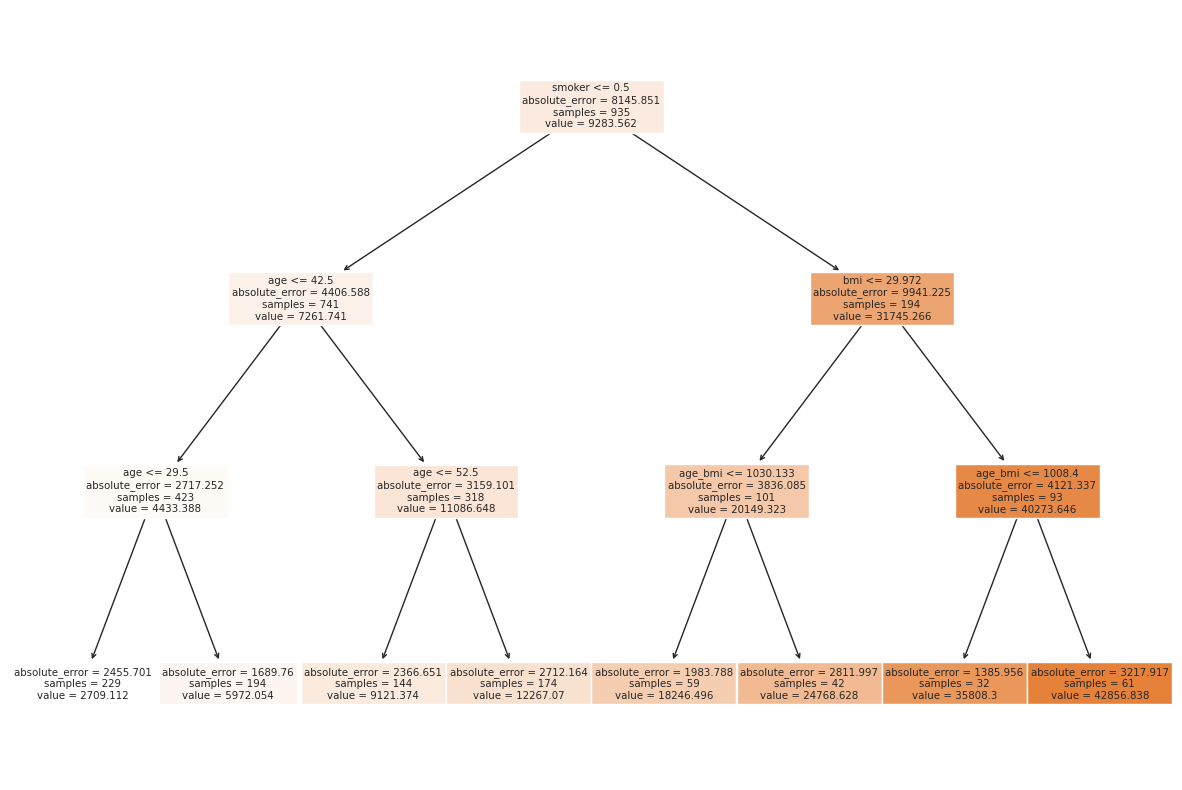

In [ ]:
# Visualizar a árvore de decisão
plt.figure(figsize=(15, 10))
tree.plot_tree(modelo, filled=True, feature_names=X.columns)
plt.show()

Este modelo considera a variável smoker como a mais importante para prever o custo do seguro, ele classificou 935 amostras e o valor estimado para o custo seria 9.136 (lembrando que a variável custo está com a transformação logarítmica) se a smoker for menor ou igual a 0.5.

Se a primeira condição foi verdadeira ele irá avaliar a variável age <=42.5 e se falso ele irá avaliar a variável bmi <=29.972 e assim sucessivamente.

Através da árvore também, podemos dizer que as variáveis mais importantes para nosso modelo são smoker, age e bmi. (Testamos o modelo com diferentes variáveis e não houve diferenciação na estrutura da árvore.)

# 7. KNN Regressor

https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html#sphx-glr-auto-examples-neighbors-plot-regression-py

In [ ]:
#importando as bibliotecas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

In [ ]:
#definindo o conjunto de dados
X = df_tratamento[[
      'age', 'sex', 'bmi', 'children', 'smoker',
       'has_children', 'age_bmi', 'age_children', 'charge_child',
       'bmi_category_dummie', 'age_group_dummie',
       'region_dummie', 'smoker_per_region']]

y = df_tratamento['charges']

In [ ]:
# Escalonar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Treinar o modelo KNN Regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_scaled, y_train)

KNeighborsRegressor()

Treinando o modelo considerando 5 vizinhos para as comparações dos dados próximos.

In [ ]:
# Avaliar o modelo
y_pred = knn_regressor.predict(X_test_scaled)

In [ ]:
# Calcular o R2 Score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

R2 Score: 0.799768612428992


Aproximadamente 80% da variabilidade nos dados de charges pode ser explicada pelas variáveis independentes fornecidas ao modelo KNN Regressor. Isso é geralmente considerado um bom resultado, indicando que o modelo tem uma boa capacidade de predição.

# 8. Conclusão


Os três modelos tiveram um coeficiente de determinação muito similar quando rodamos usando a variável resposta transformada logaritmicamente, aproximadamente 79%. Quando rodamos os modelos com a variável resposta original, a árvore regressora se destacou melhorando em 5% o coeficiente, enquanto a regressão logística e o KNN diminuiram em 2% seus coeficientes.

Considerando esse cenário, a árvore de regressão é o melhor modelo para o problema, com R² = 84.72% pois, a maioria das nossas variáveis independentes tinham relações não lineares entre a variável dependente então a árvore pode capturar melhor essas relações atrevés das suas divisões, assim como as variáveis de interação criadas ja que a árvore pode considerar diferentes combinações de características entre elas.

